# Exoplanet KOI Tabular — Entrenamiento y Exportación de Modelo
Este notebook entrena un clasificador sobre KOI (cumulative), exporta artefactos (Keras + scaler + label encoder + stats) y provee una prueba con TCEs.

In [ ]:
# @title Instalar dependencias
# (En Colab, esta celda puede tardar unos minutos)
!pip -q install pandas numpy scikit-learn tensorflow-cpu==2.15.0 requests joblib

ERROR: Could not find a version that satisfies the requirement tensorflow-cpu==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow-cpu==2.15.0


In [ ]:
# @title Imports
import io, json, os, requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import joblib
print("TF:", tf.__version__)

TF: 2.19.0


In [ ]:
# @title Descargar KOI cumulative (API Exoplanet Archive)
BASE = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"

cols = [
 "kepoi_name","koi_disposition","koi_pdisposition","koi_score",
 "koi_period","koi_duration","koi_depth","koi_prad","koi_srad",
 "koi_teq","koi_steff","koi_slogg","koi_smet","koi_kepmag",
 "koi_model_snr","koi_num_transits"
]

where = ("koi_disposition like 'CONFIRMED' or "
         "koi_disposition like 'CANDIDATE' or "
         "koi_disposition like 'FALSE POSITIVE'")

where = ("koi_disposition like 'CANDIDATE'")


params = {
    "table": "cumulative",
    "select": ",".join(cols),
    "where": where,
    "format": "csv"
}


r = requests.get(BASE, params=params, timeout=60)
r.raise_for_status()

print(f"URL: {r.url}")
df = pd.read_csv(io.StringIO(r.text))
print(df.shape, df.koi_disposition.value_counts())
df.to_csv("exo_full.csv", index=False)

URL: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepoi_name%2Ckoi_disposition%2Ckoi_pdisposition%2Ckoi_score%2Ckoi_period%2Ckoi_duration%2Ckoi_depth%2Ckoi_prad%2Ckoi_srad%2Ckoi_teq%2Ckoi_steff%2Ckoi_slogg%2Ckoi_smet%2Ckoi_kepmag%2Ckoi_model_snr%2Ckoi_num_transits&where=koi_disposition+like+%27CANDIDATE%27&format=csv
(1979, 16) koi_disposition
CANDIDATE    1979
Name: count, dtype: int64


In [ ]:
# @title Split train/test y preprocesamiento
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42, stratify=df["koi_disposition"])
df_tr = df_tr.dropna()
df_te = df_te.dropna()

feature_columns = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
                   'koi_srad', 'koi_teq', 'koi_steff', 'koi_slogg',
                   'koi_smet', 'koi_kepmag', 'koi_model_snr', 'koi_num_transits']

X_tr = df_tr[feature_columns].values
X_te = df_te[feature_columns].values

label_encoder = LabelEncoder()
y_tr = label_encoder.fit_transform(df_tr['koi_disposition'])
y_te = label_encoder.transform(df_te['koi_disposition'])

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

print("Clases:", label_encoder.classes_)
print("X_tr:", X_tr.shape, "y_tr:", y_tr.shape)

Clases: ['CANDIDATE']
X_tr: (1104, 12) y_tr: (1104,)


In [ ]:
# @title entrenar Modelo (MLP Keras)
num_classes = len(np.unique(y_tr))
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_tr.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=200, batch_size=32, verbose=1)

test_loss, test_acc = model.evaluate(X_te, y_te, verbose=0)
print("Accuracy test:", round(test_acc, 4))

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/200

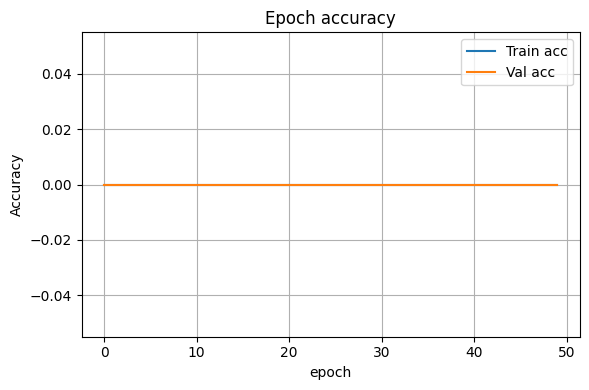

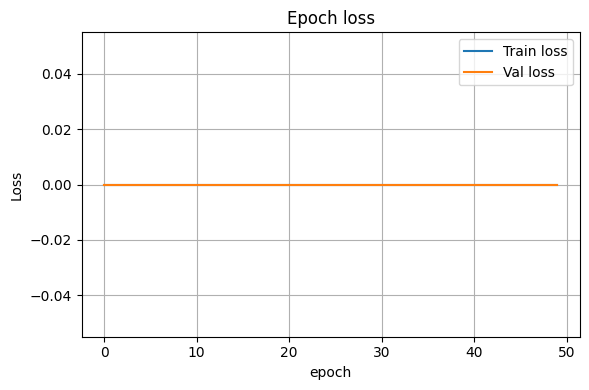

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


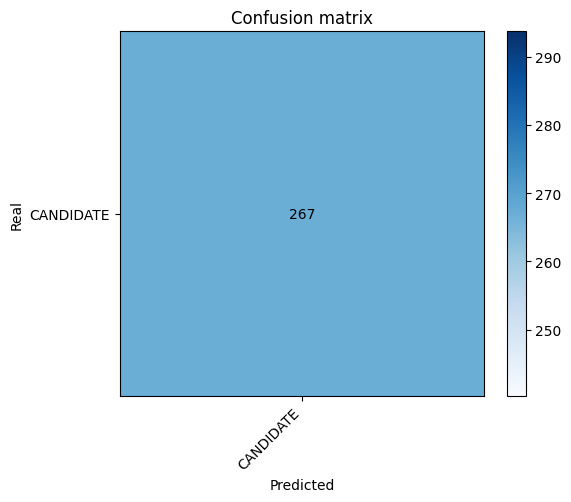

              precision    recall  f1-score   support

   CANDIDATE      1.000     1.000     1.000       267

    accuracy                          1.000       267
   macro avg      1.000     1.000     1.000       267
weighted avg      1.000     1.000     1.000       267



In [ ]:
# === Gráficas y métricas del entrenamiento (Keras) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) Curvas de aprendizaje (accuracy y loss)

plt.figure(figsize=(6,4))
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Epoch accuracy')
plt.xlabel('epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(1,1,1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Epoch loss')
plt.xlabel('epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# 2) Matriz de confusión
y_proba = model.predict(X_te)
y_pred  = np.argmax(y_proba, axis=1)

cm = confusion_matrix(y_te, y_pred)
classes = list(label_encoder.classes_)  # ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'] típicamente

plt.figure(figsize=(6,5))
im = plt.imshow(cm, cmap='Blues')
plt.colorbar(im)
plt.title('Confusion matrix')
plt.xlabel('Predicted'); plt.ylabel('Real')
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=range(len(classes)), labels=classes)

# anotar valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# 3) Reporte de clasificación
print(classification_report(y_te, y_pred, target_names=classes, digits=3))

In [ ]:
# @title Exportar artefactos (para GitHub / Hugging Face)
import json, joblib, tensorflow as tf

# 1) modelo keras
tf.keras.models.save_model(model, "modelo_tabular.h5")

# 2) scaler y label_encoder
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

# 3) medianas + orden de columnas
feature_stats = {
    "feature_columns": feature_columns,
    "medians": df_tr[feature_columns].median(numeric_only=True).to_dict()
}
with open("feature_stats.json","w") as f:
    json.dump(feature_stats, f, indent=2)

print("Artefactos exportados:",
      ["modelo_tabular.h5","scaler.pkl","label_encoder.pkl","feature_stats.json"])

Artefactos exportados: ['modelo_tabular.h5', 'scaler.pkl', 'label_encoder.pkl', 'feature_stats.json']


In [ ]:
# @title (Prueba) Inferencia con TCE (objetos 'desconocidos')
import io, requests, pandas as pd, numpy as np

def predict_with_artifacts(input_df: pd.DataFrame):
    # Cargar artefactos locales
    m = tf.keras.models.load_model("modelo_tabular.h5")
    sc = joblib.load("scaler.pkl")
    le = joblib.load("label_encoder.pkl")
    with open("feature_stats.json") as f:
        stats = json.load(f)

    feature_columns = stats["feature_columns"]
    medians = stats["medians"]

    # asegurar columnas
    for c in feature_columns:
        if c not in input_df.columns:
            input_df[c] = np.nan
    input_df = input_df[feature_columns].copy()
    for c in feature_columns:
        if input_df[c].isna().any():
            input_df[c] = input_df[c].fillna(medians.get(c, 0.0))

    X = sc.transform(input_df.values)
    probs = m.predict(X, verbose=0)
    classes = list(le.classes_)
    idx = np.argmax(probs, axis=1)
    pred = le.inverse_transform(idx)
    return pred, probs, classes

# Descargar 2 TCEs de mayor SNR
TAP_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
query = """
SELECT TOP 2
  kepid, tce_plnt_num, tce_period, tce_duration, tce_depth, tce_model_snr
FROM q1_q17_dr25_tce
WHERE tce_period > 0 AND tce_duration > 0 AND tce_depth > 0
ORDER BY tce_model_snr DESC
"""
r = requests.get(TAP_URL, params={"query": query, "format": "csv"}, timeout=90)
r.raise_for_status()
tce = pd.read_csv(io.StringIO(r.text))
tce.columns = [c.strip().lower() for c in tce.columns]

# Map mínimo TCE -> features KOI
feature_columns = json.load(open("feature_stats.json"))["feature_columns"]
cases = pd.DataFrame(index=tce.index, columns=feature_columns, dtype="float64")
mapping = {
    "koi_period": "tce_period",
    "koi_duration": "tce_duration",
    "koi_depth": "tce_depth",
    "koi_model_snr": "tce_model_snr",
}
for feat, src in mapping.items():
    if src in tce.columns:
        cases[feat] = pd.to_numeric(tce[src], errors="coerce")

pred, probs, classes = predict_with_artifacts(cases)
print("Predicción para TCEs:", pred)
print("Clases:", classes)